# Resources Used:

In [1]:
# https://cierra-andaur.medium.com/using-k-means-clustering-for-image-segmentation-fe86c3b39bf4
# https://towardsdatascience.com/image-segmentation-using-k-means-clustering-d8f3723e8b6e
# https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# ChatGPT for TypeErrors and AttributeErrors

# Implementing Libraries

In [1]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# K-Means Clustering Function

In [2]:
def kmeans_color_pixels(k, data_points):
    # Reshape data_points to 2D array if needed
    if data_points.ndim == 3:
        h, w, d = data_points.shape
        data_points = np.reshape(data_points, (h * w, d))

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=k)
    cluster_indices = kmeans.fit_predict(data_points)
    cluster_centers = kmeans.cluster_centers_

    return cluster_indices, cluster_centers

In [3]:
def compute_likelihood(pixel, cluster_centers, beta):
    # Compute Euclidean distances between pixel and cluster centers
    distances = np.linalg.norm(cluster_centers - pixel, axis=1)

    # Compute likelihood using exponential function
    likelihood = np.exp(-beta * distances)

    # Normalize likelihood
    likelihood /= np.sum(likelihood)

    return likelihood

In [4]:
def overall_likelihood(pixel, foreground_centers, background_centers, beta_foreground, beta_background):
    # Compute likelihoods for foreground and background clusters
    foreground_likelihood = compute_likelihood(pixel, foreground_centers, beta_foreground)
    background_likelihood = compute_likelihood(pixel, background_centers, beta_background)

    # Weighted sum of likelihoods
    overall_likelihood = foreground_likelihood + background_likelihood

    return overall_likelihood

In [5]:
def extract_seed_pixels(image, mask, num_clusters):
    # Extract pixels from image based on mask
    foreground_pixels = image[mask > 0]
    background_pixels = image[mask == 0]

    # Perform K-Means clustering on foreground and background pixels
    _, foreground_centers = kmeans_color_pixels(num_clusters, foreground_pixels)
    _, background_centers = kmeans_color_pixels(num_clusters, background_pixels)

    return foreground_centers, background_centers

# Main

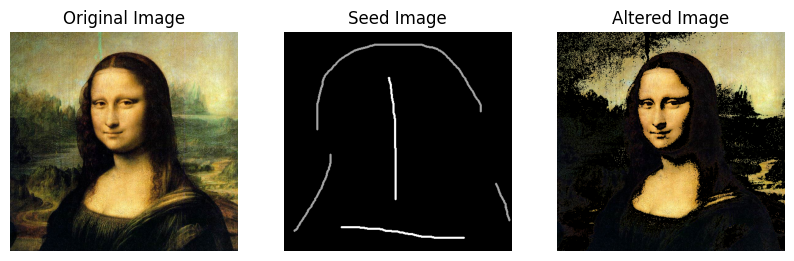

In [8]:
# Load the original image and the seed image
original_image = cv2.imread('Mona-lisa.png')
seed_image = cv2.imread('Mona-lisa_stroke1.png', cv2.IMREAD_GRAYSCALE)

# Convert the seed image to a binary mask
mask = np.where(seed_image > 0, 1, 0)

# Define parameters
num_clusters = 70
beta_foreground = 0.1
beta_background = 0.1

# Extract seed pixels
foreground_centers, background_centers = extract_seed_pixels(original_image, mask, num_clusters)

# Create an empty image for the altered image
altered_image = np.zeros_like(original_image)

# Iterate over each pixel in the original image
for i in range(original_image.shape[0]):
    for j in range(original_image.shape[1]):
        # Compute likelihood for the pixel
        pixel = original_image[i, j]
        pixel_likelihood = overall_likelihood(pixel, foreground_centers, background_centers, beta_foreground, beta_background)
        
        # Determine if the pixel belongs to foreground or background based on likelihoods
        if pixel_likelihood[0] > pixel_likelihood[1]:  # Foreground likelihood is greater
            altered_image[i, j] = original_image[i, j]  # Set pixel color to original image color
        else:
            # Set pixel to black color
            altered_image[i, j] = [0, 0, 0]

# Display original image
plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Display seed image
plt.subplot(1, 3, 2)
plt.imshow(seed_image, cmap='gray')
plt.title('Seed Image')
plt.axis('off')

# Display altered image
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(altered_image, cv2.COLOR_BGR2RGB))
plt.title('Altered Image')
plt.axis('off')

plt.show()